# LogP Analysis

In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


## Imports

In [2]:
import os
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from irelease.utils import generate_smiles, canonical_smiles
import nb_utils as nbu
from math import ceil
from sklearn.manifold import TSNE
import pandas as pd
import rdkit.Chem as Chem
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Draw

RDKit WARNING: [13:34:44] Enabling RDKit 2019.09.3 jupyter extensions


mol_metrics: reading NP model ...
loaded in 0.66459059715271
mol_metrics: reading SA model ...
loaded in 1.9947707653045654


In [3]:
DrawingOptions.atomLabelFontSize = 50
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3

## Load SMILES files

In [4]:
ppo_grl_train = 'logp/LogP_IReLeaSE-PPO_with_irl.json'
ppo_grl_eval = 'logp/LogP_smiles_biased_ppo_grl_eval.json'
ppo_baseline_reward_train = 'logp/LogP_IReLeaSE-PPO__baseline_reward.json'
ppo_baseline_reward_eval = 'logp/LogP_smiles_biased_ppo_baseline_reward_eval.json'
reinforce_train = 'logp/LogP_IReLeaSE-REINFORCE_no_irl.json'
reinforce_eval = 'logp/LogP_smiles_biased_reinforce_eval.json'
reinforce_grl_train = 'logp/LogP_IReLeaSE-REINFORCE_with_irl.json'
reinforce_grl_eval = 'logp/LogP_smiles_biased_reinforce_grl_eval.json'

In [5]:
ppo_grl_smiles_valid,  ppo_grl_smiles_invalid = nbu.smiles_from_json_data(ppo_grl_eval)
ppo_grl_conv = nbu.get_convergence_data(ppo_grl_train)
ppo_baseline_reward_smiles_valid, ppo_baseline_reward_smiles_invalid = nbu.smiles_from_json_data(ppo_baseline_reward_eval)
ppo_baseline_reward_conv = nbu.get_convergence_data(ppo_baseline_reward_train)
reinforce_smiles_valid, reinforce_smiles_invalid = nbu.smiles_from_json_data(reinforce_eval)
reinforce_conv = nbu.get_convergence_data(reinforce_train)
reinforce_grl_smiles_valid, reinforce_grl_smiles_invalid = nbu.smiles_from_json_data(reinforce_grl_eval)
reinforce_grl_conv = nbu.get_convergence_data(reinforce_grl_train)
len(ppo_grl_smiles_valid), len(ppo_baseline_reward_smiles_valid), len(reinforce_smiles_valid), len(reinforce_grl_smiles_valid)

(4606, 4975, 7707, 7237)

In [6]:
# CSV files containing predictions/evaluations
preds_ppo_grl_eval = pd.read_csv('logp/LogP_smiles_biased_ppo_grl_eval.csv')
preds_ppo_baseline_reward_eval = pd.read_csv('logp/LogP_smiles_biased_ppo_baseline_reward_eval.csv')
preds_reinforce_eval = pd.read_csv('logp/LogP_smiles_biased_reinforce_eval.csv')
preds_reinforce_grl_eval = pd.read_csv('logp/LogP_smiles_biased_reinforce_grl_eval.csv')
preds_demo = pd.read_csv('logp/logp_biased.csv')
preds_unbiased = pd.read_csv('logp/logp_unbiased.csv')
preds_ppo_grl_eval.shape, preds_ppo_baseline_reward_eval.shape, preds_reinforce_eval.shape, preds_reinforce_grl_eval.shape, preds_demo.shape, preds_unbiased.shape

((4606, 2), (4975, 2), (7707, 2), (7237, 2), (10000, 2), (10000, 2))

In [7]:
preds_ppo_grl_eval.shape[0] / 10000. * 100., preds_ppo_baseline_reward_eval.shape[0] / 10000. * 100., preds_reinforce_eval.shape[0] / 10000. * 100., preds_reinforce_grl_eval.shape[0] / 10000. * 100., preds_demo.shape[0] / 10000. * 100., preds_unbiased.shape[0] / 10000. * 100.

(46.06, 49.75, 77.07000000000001, 72.37, 100.0, 100.0)

## Evaluate SMILES

In [8]:
generators = nbu.data_provider('../../data/logp_smiles_biased.smi', '../../data/unbiased_smiles.smi')

In [9]:
demo_smiles = generators['demo_data'].random_training_set_smiles(10000)
demo_smiles = list(set(demo_smiles))
unbiased_smiles = generators['unbiased_data'].random_training_set_smiles(10000)
unbiased_smiles = list(set(unbiased_smiles))

In [10]:
demo_smiles[0], unbiased_smiles[0]

('CCc1ccccc1C(=O)Nc1ccccc1Nc1ccccc1',
 'CCCC(COC(=O)CC#CCNC(C)=O)C(=O)NC1CCCCC1')

In [11]:
preds_ppo_grl_smiles = preds_ppo_grl_eval['prediction'].tolist()
preds_ppo_baseline_reward_smiles = preds_ppo_baseline_reward_eval['prediction'].tolist()
preds_reinforce_smiles = preds_reinforce_eval['prediction'].tolist()
preds_reinforce_grl_smiles = preds_reinforce_grl_eval['prediction'].tolist()
preds_demo_smiles = preds_demo['prediction'].tolist()
preds_unbiased_smiles = preds_unbiased['prediction'].tolist()

## KDE plots

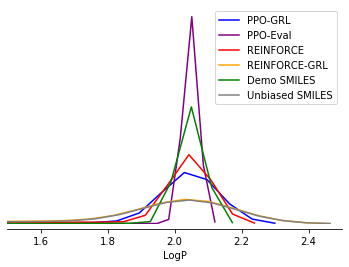

In [12]:
sns.kdeplot(preds_ppo_grl_smiles, label='PPO-GRL', shade=False, color='blue')
sns.kdeplot(preds_ppo_baseline_reward_smiles, label='PPO-Eval', shade=False, color='purple')
sns.kdeplot(preds_reinforce_smiles, label='REINFORCE', shade=False, color='red')
ax = sns.kdeplot(preds_reinforce_grl_smiles, label='REINFORCE-GRL', shade=False, color='orange')
sns.kdeplot(preds_demo_smiles, label='Demo SMILES', shade=False, color='green')
ax = sns.kdeplot(preds_unbiased_smiles, label='Unbiased SMILES', shade=False, color='gray')
plt.xlabel('LogP')
# ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# ax.set_xticks([])
plt.xlim([1.5, 2.5])
sns.despine(offset=5, left=True, bottom=False)
plt.savefig('logp/logp_kde_plots.pdf')
plt.show()

## Convergence plot

In [13]:
ppo_grl_biased = ppo_grl_conv['biased']
ppo_baseline_reward_biased = ppo_baseline_reward_conv['biased']
reinforce_biased = reinforce_conv['biased']
reinforce_grl_biased = reinforce_grl_conv['biased']
demo_vals = reinforce_grl_conv['demo']
unbiased_vals = reinforce_grl_conv['baseline']

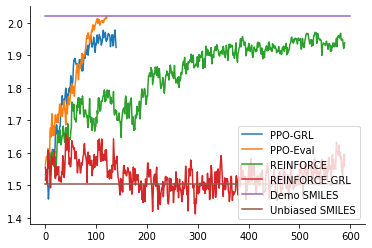

In [14]:
offset = 10
plt.plot(nbu.smoothing_values(ppo_grl_biased, 0.6)[offset:150])
plt.plot(nbu.smoothing_values(ppo_baseline_reward_biased, 0.6)[offset:])
plt.plot(nbu.smoothing_values(reinforce_biased, 0.6)[offset:])
plt.plot(nbu.smoothing_values(reinforce_grl_biased, 0.6)[offset:])
plt.plot(demo_vals)
plt.plot(unbiased_vals)
plt.legend(['PPO-GRL','PPO-Eval','REINFORCE','REINFORCE-GRL', 'Demo SMILES', 'Unbiased SMILES'], loc='lower right')
plt.savefig('logp/logp_irl_vs_rl_convergence.pdf')
sns.despine()

## t-SNE plot

In [15]:
hparams = {'d_model': 1500,
            'dropout': 0.0,
            'monte_carlo_N': 5,
            'use_monte_carlo_sim': True,
            'no_mc_fill_val': 0.0,
            'gamma': 0.97,
            'episodes_to_train': 10,
            'gae_lambda': 0.95,
            'ppo_eps': 0.2,
            'ppo_batch': 1,
            'ppo_epochs': 5,
            'entropy_beta': 0.01,
            'use_true_reward': False,
            'baseline_reward': False,
            'reward_params': {'num_layers': 2,
                              'd_model': 512,
                              'unit_type': 'gru',
                              'demo_batch_size': 32,
                              'irl_alg_num_iter': 5,
                              'dropout': 0.2,
                              'use_attention': False,
                              'use_validity_flag': True,
                              'bidirectional': True,
                              'optimizer': 'adadelta',
                              'optimizer__global__weight_decay': 0.0005,
                              'optimizer__global__lr': 0.001, },
            'agent_params': {'unit_type': 'gru',
                             'num_layers': 2,
                             'stack_width': 1500,
                             'stack_depth': 200,
                             'optimizer': 'adadelta',
                             'optimizer__global__weight_decay': 0.0000,
                             'optimizer__global__lr': 0.001},
            'critic_params': {'num_layers': 2,
                              'd_model': 256,
                              'dropout': 0.2,
                              'unit_type': 'lstm',
                              'optimizer': 'adadelta',
                              'optimizer__global__weight_decay': 0.00005,
                              'optimizer__global__lr': 0.001},
            'expert_model_params': {'model_dir': './model_dir/expert_rnn_reg',
                                    'd_model': 128,
                                    'rnn_num_layers': 2,
                                    'dropout': 0.8,
                                    'is_bidirectional': False,
                                    'unit_type': 'lstm'}
            }

In [16]:
init_dict = nbu.initialize(hparams, generators['demo_data'], generators['unbiased_data'], True)

In [17]:
# encoder = init_dict['encoder']
# ppo_reward_net_rnn = init_dict['reward_net_rnn']
# ppo_reward_net = init_dict['reward_net']
# ppo_reward_net.load_state_dict(nbu.load_model_weights('../model_dir/LogP_irelease_stack-rnn_gru_ppo_reward_net_2020_07_10__08_30_37_1.978_300.mod'))

In [18]:
# with torch.set_grad_enabled(False):
#     reward_lst, logits_lst = [], []
#     tsne_smiles = ppo_grl_smiles_valid + ppo_grl_smiles_invalid
#     for i in range(0, len(tsne_smiles), 500):
#         inp, valid_vec = nbu.smiles_to_tensor(['<'+s+'>' for s in tsne_smiles[i:i+500]])
#         enc_out = encoder([inp, valid_vec])
#         reward, logits = ppo_reward_net_rnn(enc_out, return_logits=True)
#         reward_lst.append(reward)
#         logits_lst.append(logits)
#     reward = torch.cat(reward_lst)
#     logits = torch.cat(logits_lst)

In [19]:
# logits.shape, reward.shape

In [20]:
# tsne_rep = TSNE(n_components=2).fit_transform(logits.detach().cpu().numpy())
# tsne_data = pd.DataFrame({'x':tsne_rep[:,0], 'y':tsne_rep[:,1]})
# tsne_rep.shape

In [21]:
# plt.figure(figsize=(10,10))
# points = plt.scatter(tsne_data['x'], tsne_data['y'], c=reward.detach().cpu().numpy().reshape(-1,), s=50, cmap="Spectral")
# cb = plt.colorbar(points, ticks=None)
# cb.outline.set_visible(False)
# ax = sns.scatterplot(x="x", y="y", hue=reward.detach().cpu().numpy().reshape(-1,), data=tsne_data, 
#                     legend=False, palette='Spectral', edgecolor='black', linewidth=.01)
# v = []
# # valid SMILES
# while True:
#     va_idx = np.random.randint(len(ppo_grl_smiles_valid))
#     comp = ppo_grl_smiles_valid[va_idx]
#     i = len(v)+1
#     if len(comp) <= 50:
#         v.append(comp)
#         ax.annotate('val-'+str(i), xy=(tsne_data['x'][va_idx], tsne_data['y'][va_idx]), 
#                     xytext=(-20+(i*10),50), 
#                     arrowprops=dict(facecolor='black', arrowstyle='-'),
#                    horizontalalignment='right', verticalalignment='top')
#         if len(v) == 3:
#             break

# inv = []
# # invalid SMILES
# for i in range(3):
#     inv_idx = np.random.randint(len(ppo_grl_smiles_invalid))
#     inv.append(ppo_grl_smiles_invalid[inv_idx])
#     ax.annotate('inv-'+str(i+1), xy=(tsne_data['x'][len(ppo_grl_smiles_valid) + inv_idx], 
#                     tsne_data['y'][len(ppo_grl_smiles_valid) + inv_idx]), 
#                 xytext=(-50+(i*10),40), arrowprops=dict(facecolor='black', arrowstyle='-'),
#                horizontalalignment='right', verticalalignment='top')

# print('selected valid:\n', v)
# print('selected invalid:\n', inv)
# plt.axis('off')
# plt.savefig('logp/logp_ppo_grl_tsne.pdf')
# plt.show()

##  Draw random SMILES

In [22]:
vis_mols = [Chem.MolFromSmiles(sm, sanitize=True) for sm in set(ppo_grl_smiles_valid) if len(sm)]# <= 50]
sanitized_gen_mols = [vis_mols[i] for i in np.where(np.array(vis_mols) != None)[0]]
len(sanitized_gen_mols)

4604

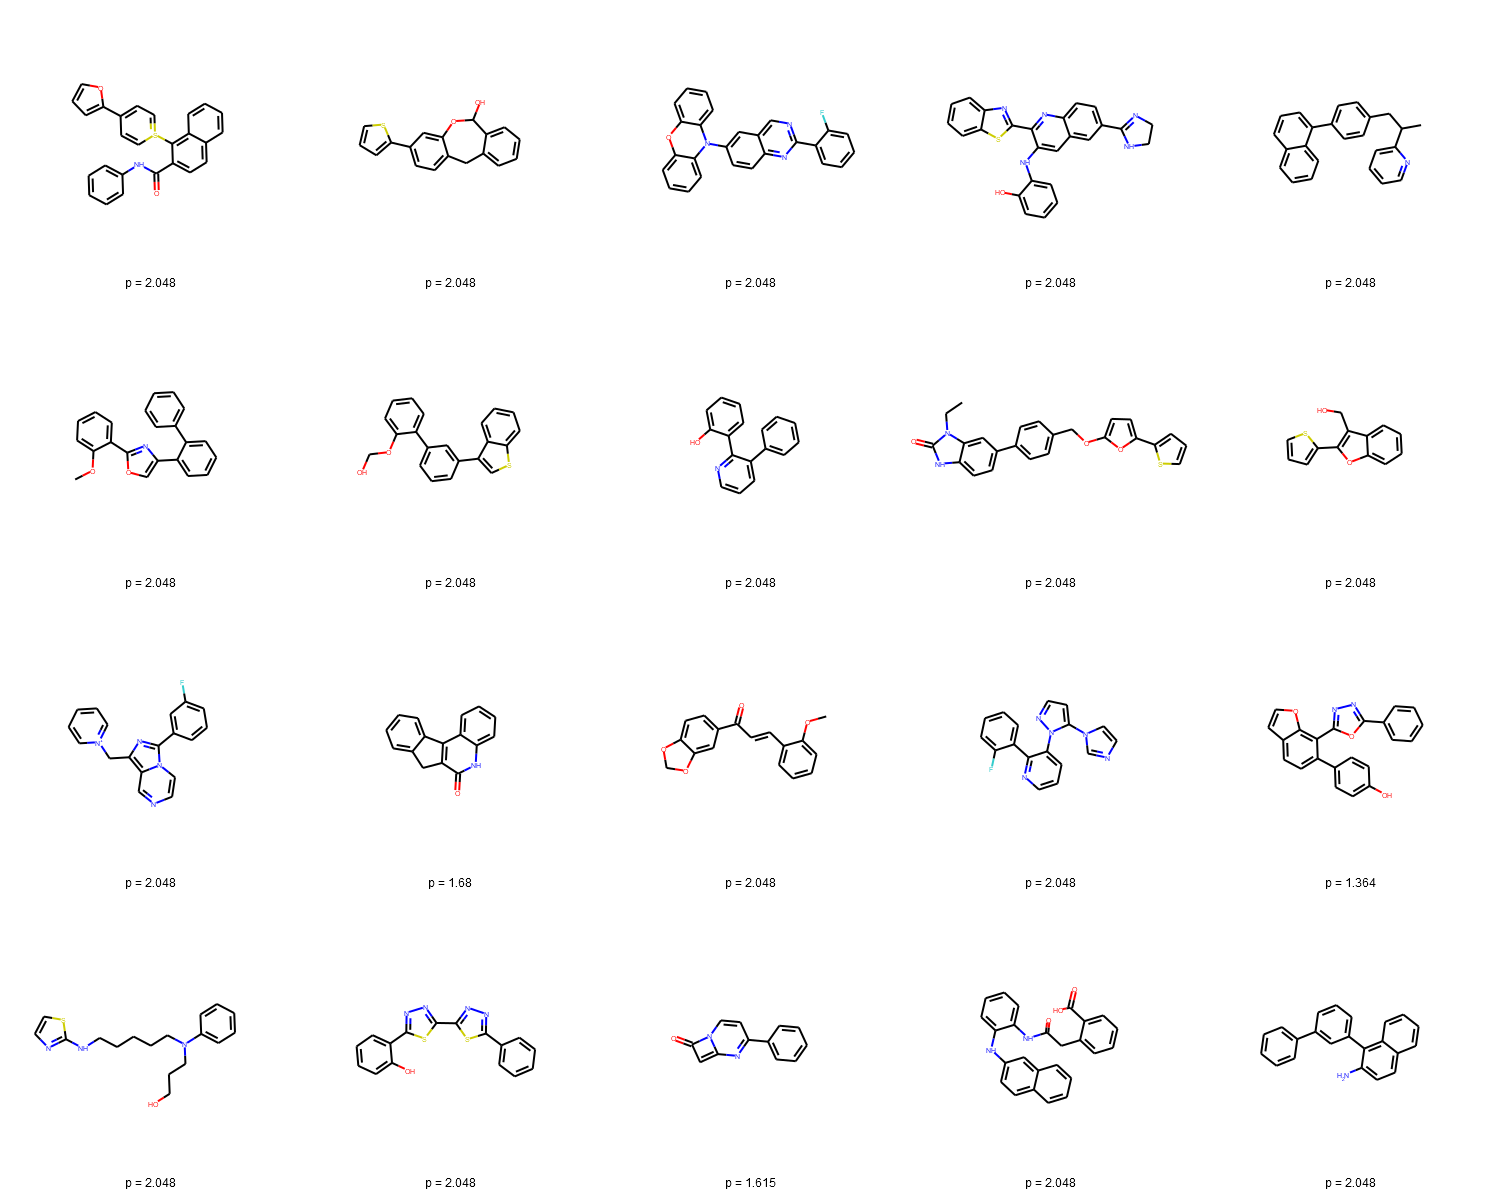

In [23]:
n_to_draw = 20
ind = np.random.randint(0, len(sanitized_gen_mols), n_to_draw)
mols_to_draw = [sanitized_gen_mols[i] for i in ind]
legends = ['p = ' + str(round(float(preds_ppo_grl_smiles[i]), 3)) for i in ind]
Draw.MolsToGridImage(mols_to_draw, molsPerRow=5, subImgSize=(300,300), legends=legends)

In [24]:
for i, mol in enumerate(mols_to_draw):
    print(f'{Chem.MolToSmiles(mol)}\t\t{legends[i]}')

O=C(Nc1ccccc1)c1ccc2ccccc2c1S1=CC=C(c2ccco2)C=C1		p = 2.048
OC1Oc2cc(-c3cccs3)ccc2Cc2ccccc21		p = 2.048
Fc1ccccc1-c1ncc2cc(N3c4ccccc4Oc4ccccc43)ccc2n1		p = 2.048
Oc1ccccc1Nc1cc2cc(C3=NCCN3)ccc2nc1-c1nc2ccccc2s1		p = 2.048
CC(Cc1ccc(-c2cccc3ccccc23)cc1)c1ccccn1		p = 2.048
COc1ccccc1-c1nc(-c2ccccc2-c2ccccc2)co1		p = 2.048
OCOc1ccccc1-c1cccc(-c2csc3ccccc23)c1		p = 2.048
Oc1ccccc1-c1ncccc1-c1ccccc1		p = 2.048
CCn1c(=O)[nH]c2ccc(-c3ccc(COc4ccc(-c5cccs5)o4)cc3)cc21		p = 2.048
OCc1c(-c2cccs2)oc2ccccc12		p = 2.048
Fc1cccc(-c2nc(C[n+]3ccccc3)c3cnccn23)c1		p = 2.048
O=c1[nH]c2ccccc2c2c1Cc1ccccc1-2		p = 1.68
COc1ccccc1C=CC(=O)c1ccc2c(c1)OCO2		p = 2.048
Fc1ccccc1-c1ncccc1-n1nccc1-n1ccnc1		p = 2.048
Oc1ccc(-c2ccc3ccoc3c2-c2nnc(-c3ccccc3)o2)cc1		p = 1.364
OCCCN(CCCCCNc1nccs1)c1ccccc1		p = 2.048
Oc1ccccc1-c1nnc(-c2nnc(-c3ccccc3)s2)s1		p = 2.048
O=C1C=C2N=C(c3ccccc3)C=CN12		p = 1.615
O=C(Cc1ccccc1C(=O)O)Nc1ccccc1Nc1ccc2ccccc2c1		p = 2.048
Nc1ccc2ccccc2c1-c1cccc(-c2ccccc2)c1		p = 2.048


In [25]:
# Save selected compounds to file
# os.makedirs('./drd2_samples', exist_ok=True)
# for i, mol in enumerate(mols_to_draw):
#     Draw.MolToImageFile(mol, f'./drd2/sample_compound_{i+1}.png')

## Molecule metrics

In [26]:
def mol_metrics(df):
    results = {}
    num_can = 0
    for idx, df_smiles in enumerate([df, df[df['prediction'] <= np.mean(demo_vals)]]):
        new_smiles, valid_vec = canonical_smiles(df_smiles['SMILES'].tolist())
        smiles = []
        for i, s in enumerate(new_smiles):
            if valid_vec[i] == 1:
                smiles.append(s)
        smiles = set(smiles)
        eval_dict = nbu.evaluate(smiles, demo_smiles)
        eval_dict['Num of canonical SMILES'] = len(smiles)
        if idx==0:
            num_can = len(smiles)
        eval_dict['percentage of valid'] = df_smiles.shape[0] / 10000. * 100.
        if idx==1:            
            eval_dict['percentage in threshold (canonical)'] = len(smiles) / num_can
        results['no_threshold' if idx==0 else 'with_threshold'] = eval_dict
    return results

In [27]:
mol_metrics(preds_ppo_grl_eval)

{'no_threshold': {'novelty': 0.997174527276679,
  'hard_novelty': 0.997174527276679,
  'soft_novelty': 0.9980221690936752,
  'external_diversity': 0.15889622599727515,
  'internal_diversity': 0.9033379495173814,
  'conciseness': 1.0,
  'solubility': 0.8361822897454904,
  'naturalness': 0.5795384413566078,
  'synthesizability': 0.769795842996807,
  'druglikeliness': 0.49443391979311657,
  'Num of canonical SMILES': 4604,
  'percentage of valid': 46.06},
 'with_threshold': {'novelty': 0.9972813774354327,
  'hard_novelty': 0.9972813774354327,
  'soft_novelty': 0.998096964204803,
  'external_diversity': 0.1362280740270292,
  'internal_diversity': 0.901452521656195,
  'conciseness': 1.0,
  'solubility': 0.8537587710765323,
  'naturalness': 0.5791140735886102,
  'synthesizability': 0.7750494503936833,
  'druglikeliness': 0.4885183389321773,
  'Num of canonical SMILES': 4414,
  'percentage of valid': 44.15,
  'percentage in threshold (canonical)': 0.9587315377932233}}

In [28]:
mol_metrics(preds_ppo_baseline_reward_eval)

{'no_threshold': {'novelty': 0.9985926819461198,
  'hard_novelty': 0.9985926819461198,
  'soft_novelty': 0.9990148773622838,
  'external_diversity': 0.06220285424194699,
  'internal_diversity': 0.7330554005388912,
  'conciseness': 1.0,
  'solubility': 0.9822385578365563,
  'naturalness': 0.7311444379021131,
  'synthesizability': 0.449333791279475,
  'druglikeliness': 0.07546083287367394,
  'Num of canonical SMILES': 4975,
  'percentage of valid': 49.75},
 'with_threshold': {'novelty': 0.998587855557797,
  'hard_novelty': 0.998587855557797,
  'soft_novelty': 0.9990114988904578,
  'external_diversity': 0.059644125107887136,
  'internal_diversity': 0.7315568555383373,
  'conciseness': 1.0,
  'solubility': 0.9840369462207363,
  'naturalness': 0.7316532142606464,
  'synthesizability': 0.44844026092452277,
  'druglikeliness': 0.07384604499066233,
  'Num of canonical SMILES': 4957,
  'percentage of valid': 49.57,
  'percentage in threshold (canonical)': 0.9963819095477386}}

In [29]:
mol_metrics(preds_reinforce_eval)

{'no_threshold': {'novelty': 0.9887056990782812,
  'hard_novelty': 0.9887056990782812,
  'soft_novelty': 0.9920939893547968,
  'external_diversity': 0.10119355087214596,
  'internal_diversity': 0.8972961642753574,
  'conciseness': 1.0,
  'solubility': 0.7740674018327451,
  'naturalness': 0.5798363852159544,
  'synthesizability': 0.8272863650362793,
  'druglikeliness': 0.6176738369943735,
  'Num of canonical SMILES': 7704,
  'percentage of valid': 77.07000000000001},
 'with_threshold': {'novelty': 0.988544474393531,
  'hard_novelty': 0.988544474393531,
  'soft_novelty': 0.9919811320754717,
  'external_diversity': 0.09389455114730122,
  'internal_diversity': 0.8966174205831059,
  'conciseness': 1.0,
  'solubility': 0.7866212659368129,
  'naturalness': 0.5795723570875683,
  'synthesizability': 0.8298666685889589,
  'druglikeliness': 0.6163059883144388,
  'Num of canonical SMILES': 7420,
  'percentage of valid': 74.22999999999999,
  'percentage in threshold (canonical)': 0.9631360332294912

In [30]:
mol_metrics(preds_reinforce_grl_eval)

{'no_threshold': {'novelty': 0.9986155337117542,
  'hard_novelty': 0.9986155337117542,
  'soft_novelty': 0.9990308735982278,
  'external_diversity': 0.34659585519145314,
  'internal_diversity': 0.9153346707475208,
  'conciseness': 1.0,
  'solubility': 0.6633311081106068,
  'naturalness': 0.5513309274336486,
  'synthesizability': 0.6887360776002116,
  'druglikeliness': 0.6274521524799118,
  'Num of canonical SMILES': 7225,
  'percentage of valid': 72.37},
 'with_threshold': {'novelty': 0.9983541803818301,
  'hard_novelty': 0.9983541803818301,
  'soft_novelty': 0.9988479262672811,
  'external_diversity': 0.29974660342667137,
  'internal_diversity': 0.9128239455641082,
  'conciseness': 1.0,
  'solubility': 0.7146759512649862,
  'naturalness': 0.5440758758733222,
  'synthesizability': 0.7060354089021488,
  'druglikeliness': 0.6253007303564587,
  'Num of canonical SMILES': 6076,
  'percentage of valid': 60.86,
  'percentage in threshold (canonical)': 0.8409688581314879}}

In [31]:
mol_metrics(preds_demo)

{'no_threshold': {'novelty': 0.3436377489931425,
  'hard_novelty': 0.3436377489931425,
  'soft_novelty': 0.5405464242951997,
  'external_diversity': 0.03403504199590801,
  'internal_diversity': 0.880189656809694,
  'conciseness': 1.0,
  'solubility': 0.8965097122756069,
  'naturalness': 0.5532253283215149,
  'synthesizability': 0.8026631599302582,
  'druglikeliness': 0.5119075138174094,
  'Num of canonical SMILES': 9188,
  'percentage of valid': 100.0},
 'with_threshold': {'novelty': 0.3444676409185804,
  'hard_novelty': 0.3444676409185804,
  'soft_novelty': 0.5411273486430062,
  'external_diversity': 0.03174228304718983,
  'internal_diversity': 0.879695673968012,
  'conciseness': 1.0,
  'solubility': 0.9005755057945567,
  'naturalness': 0.5525283952353525,
  'synthesizability': 0.8032679981430653,
  'druglikeliness': 0.5106017516812503,
  'Num of canonical SMILES': 9102,
  'percentage of valid': 99.03999999999999,
  'percentage in threshold (canonical)': 0.9906399651719634}}

In [32]:
mol_metrics(preds_unbiased)

{'no_threshold': {'novelty': 0.9993996998499249,
  'hard_novelty': 0.9993996998499249,
  'soft_novelty': 0.9995797898949474,
  'external_diversity': 0.3715187912215541,
  'internal_diversity': 0.9167539219411618,
  'conciseness': 1.0,
  'solubility': 0.6578963920366702,
  'naturalness': 0.5531815969023115,
  'synthesizability': 0.6402356251798489,
  'druglikeliness': 0.6033958836596509,
  'Num of canonical SMILES': 10000,
  'percentage of valid': 100.0},
 'with_threshold': {'novelty': 0.9992641648270787,
  'hard_novelty': 0.9992641648270787,
  'soft_novelty': 0.999484915378955,
  'external_diversity': 0.3312666173062889,
  'internal_diversity': 0.9147822824638491,
  'conciseness': 1.0,
  'solubility': 0.7193952338347817,
  'naturalness': 0.546955657991208,
  'synthesizability': 0.6598357448409186,
  'druglikeliness': 0.5974211918709271,
  'Num of canonical SMILES': 8154,
  'percentage of valid': 81.54,
  'percentage in threshold (canonical)': 0.8154}}

## RNN hidden neurons examination

In [33]:
# def plot_heatmap(smiles_list, logits, neuron=None, save=False):
#     if neuron is None:
#         neuron = np.random.randint(logits.shape[-1])
#     print(f'Plotting for neuron {neuron}')
#     for i, smiles in enumerate(smiles_list):
#         arr = logits[:len(smiles), i, neuron].reshape(1, len(smiles))
#         chars = np.array([c for c in smiles]).reshape(1,-1)
#         fig = plt.figure(figsize=(200,4))
#         sns.heatmap(arr, annot=chars, fmt='', cbar=False, 
#                     cmap=sns.color_palette("bwr", 10), annot_kws={'size':100, 'fontweight':'normal'},
#                    xticklabels=False, yticklabels=False, square=True)
#         if save:
#             os.makedirs(f'drd2/neuron_{neuron}', exist_ok=True)
#             plt.savefig(f'drd2/neuron_{neuron}/{i}.png')
#         plt.show()

In [34]:
# plot_heatmap(ppo_samples[:10], ppo_samples_neurons[:,:10,:])